In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-10-30 00:40:24.721595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:40:24.728370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:40:24.728873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps according to the reference paper

In [15]:
def trainPreprocessA(img, lab):
        
        img = tf.image.random_crop(img, [CROP_HEIGHT, CROP_WIDTH, 3])
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        img = tf.clip_by_value(img, 0.0, 255.0)
        
        return img, lab

In [16]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [17]:
def extractGenderLabel(img, lab):
    
    lab = lab['gender']
    
    return img, lab

In [18]:
def extractAgeLabel(img, lab):
    
    lab = lab['age']
    
    return img, lab

### Generate Folds for K-Folds validation

In [19]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [20]:
trainPreBatch = [("train_process_a", trainPreprocessA), 
                 ("train_extract_gender", extractGenderLabel)]

valPreBatch = [("val_process_a", valPreprocessA), 
               ("val_extract_gender", extractGenderLabel)]

In [21]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-10-30 00:40:24.987728: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 00:40:24.988492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:40:24.988850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:40:24.989150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
len(folds)

5

### Check data

In [23]:
for x,y in folds[0][0].take(1):
    pass

In [24]:
x

<tf.Tensor: shape=(4, 227, 227, 3), dtype=float32, numpy=
array([[[[1.62701584e+02, 1.32776443e+02, 1.18964485e+02],
         [1.59919342e+02, 1.30864212e+02, 1.17052261e+02],
         [1.59201355e+02, 1.30072067e+02, 1.15999641e+02],
         ...,
         [2.06219742e+02, 2.09546844e+02, 1.85461136e+02],
         [2.19730362e+02, 2.25456940e+02, 2.01690857e+02],
         [2.16103790e+02, 2.20443802e+02, 1.97371002e+02]],

        [[1.61539062e+02, 1.31613922e+02, 1.17801964e+02],
         [1.58071503e+02, 1.28146347e+02, 1.14334396e+02],
         [1.59458588e+02, 1.30004440e+02, 1.15932014e+02],
         ...,
         [2.16449753e+02, 2.19570114e+02, 1.96104614e+02],
         [2.15672638e+02, 2.20012634e+02, 1.96939835e+02],
         [2.15195145e+02, 2.19535156e+02, 1.96462341e+02]],

        [[1.62811127e+02, 1.32885986e+02, 1.19074028e+02],
         [1.59609436e+02, 1.29684280e+02, 1.14472343e+02],
         [1.60491318e+02, 1.31966141e+02, 1.15602028e+02],
         ...,
         [2

In [25]:
y

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

<IPython.core.display.Javascript object>


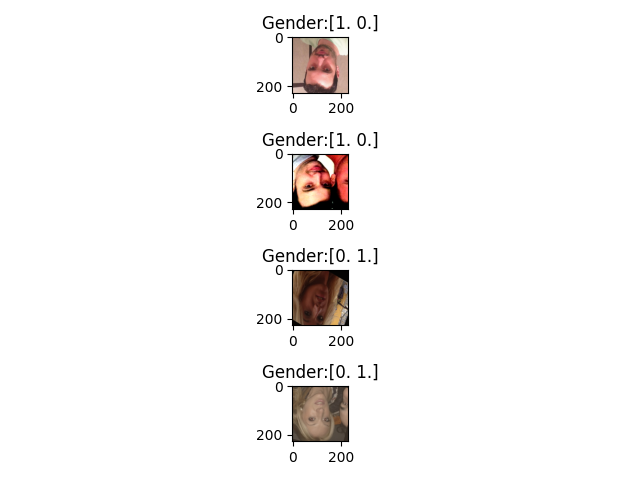

In [26]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y[i]}")
        
plt.tight_layout()

### Model

In [27]:
def createModel():
    inp = tf.keras.Input(shape=(CROP_HEIGHT, CROP_WIDTH, 3))

    backbone = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(CROP_HEIGHT, CROP_WIDTH, 3))
    backbone.trainable = False    
    
    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='fc2')

    o = tf.keras.applications.resnet_v2.preprocess_input(inp)
    o = backbone(o, training=False)
    o = flat1(o)
    o = fc1(o)
    o = do1(o)

    o = fc2(o)

    model = tf.keras.models.Model(inputs=inp, outputs=o, name='baseline_1')
    
    return model

In [28]:
model = createModel()

In [29]:
model.summary()

Model: "baseline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 227, 227, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 227, 227, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flat1 (Flatten)             (None, 131072)            0         
                                                                 
 fc1 (Dense)                 (None, 128)               1

### Compile Model

In [30]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [31]:
def schedule(epoch, lr):
    return lr

In [32]:
logBasePath = "log/baseline_resnet_4"
logPrefix = "log"

In [33]:
for i, (train, val) in enumerate(folds):
    
    model = createModel()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-10-30 00:40:40.570707: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 00:40:40.570730: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-30 00:40:40.570752: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-10-30 00:40:40.667378: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 00:40:40.668765: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-30 00:40:41.740192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  20/3528 [..............................] - ETA: 30s - loss: 1.8072 - accuracy: 0.4500  

2022-10-30 00:40:42.750156: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 29s 8ms/step - loss: 1.5193 - accuracy: 0.5540
Epoch 1/300
   1/1000 [..............................] - ETA: 22:47 - loss: 3.2219 - accuracy: 0.5000

2022-10-30 00:41:11.596307: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 00:41:11.596325: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  10/1000 [..............................] - ETA: 1:08 - loss: 6.5037 - accuracy: 0.5750

2022-10-30 00:41:12.042080: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 00:41:12.042892: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-30 00:41:12.082569: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3066 callback api events and 3041 activity events. 
2022-10-30 00:41:12.107530: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 00:41:12.133806: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_0/plugins/profile/2022_10_30_00_41_12

2022-10-30 00:41:12.167128: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/baseline_resnet_4/log_0/plugins/profile/2022_10_30_00_41_12/rachanon-pc1.trace.json.gz
2022-10-30 00:41:12.206693: I tensorflow/core/profiler/rpc/client/save_profile.cc:136]

 995/1000 [============================>.] - ETA: 0s - loss: 0.9564 - accuracy: 0.7286

2022-10-30 00:41:46.785018: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 37s 36ms/step - loss: 0.9533 - accuracy: 0.7290 - val_loss: 0.4434 - val_accuracy: 0.8021
Epoch 2/300
 998/1000 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.7505

2022-10-30 00:42:22.139433: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.5369 - accuracy: 0.7508 - val_loss: 0.4553 - val_accuracy: 0.8061
Epoch 3/300
 998/1000 [============================>.] - ETA: 0s - loss: 0.5105 - accuracy: 0.7638

2022-10-30 00:42:57.613976: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.5104 - accuracy: 0.7642 - val_loss: 0.4310 - val_accuracy: 0.7878
Epoch 4/300
 997/1000 [============================>.] - ETA: 0s - loss: 0.4993 - accuracy: 0.7600

2022-10-30 00:43:33.230626: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 36s 36ms/step - loss: 0.4992 - accuracy: 0.7600 - val_loss: 0.4840 - val_accuracy: 0.7934
Epoch 5/300
1000/1000 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.7805

2022-10-30 00:44:09.088899: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4026531840 exceeds 10% of free system memory.


1000/1000 [==============================] - 36s 36ms/step - loss: 0.4782 - accuracy: 0.7805 - val_loss: 0.4388 - val_accuracy: 0.8395
Epoch 6/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4411 - accuracy: 0.7887 - val_loss: 0.3525 - val_accuracy: 0.8272
Epoch 7/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4854 - accuracy: 0.7617 - val_loss: 0.3843 - val_accuracy: 0.8498
Epoch 8/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4205 - accuracy: 0.8027 - val_loss: 0.3513 - val_accuracy: 0.8452
Epoch 9/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4593 - accuracy: 0.7968 - val_loss: 0.3362 - val_accuracy: 0.8465
Epoch 10/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4431 - accuracy: 0.7832 - val_loss: 0.3061 - val_accuracy: 0.8614
Epoch 11/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4461 - accuracy: 0.7755 - val_loss: 0.3259 - va

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3956 - accuracy: 0.8050 - val_loss: 0.2629 - val_accuracy: 0.8972
Epoch 61/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3329 - accuracy: 0.8465 - val_loss: 0.3465 - val_accuracy: 0.8779
Epoch 62/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3896 - accuracy: 0.8135 - val_loss: 0.2423 - val_accuracy: 0.9054
Epoch 63/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.3842 - accuracy: 0.8192 - val_loss: 0.2601 - val_accuracy: 0.8833
Epoch 64/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3834 - accuracy: 0.8125 - val_loss: 0.2457 - val_accuracy: 0.9004
Epoch 65/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3682 - accuracy: 0.8363 - val_loss: 0.2623 - val_accuracy: 0.8931
Epoch 66/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3596 - accuracy: 0.8405 - val_loss: 0.2295 

1000/1000 [==============================] - 35s 35ms/step - loss: 0.3867 - accuracy: 0.8255 - val_loss: 0.2495 - val_accuracy: 0.8890
Epoch 116/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3673 - accuracy: 0.8260 - val_loss: 0.2632 - val_accuracy: 0.8786
Epoch 117/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3388 - accuracy: 0.8280 - val_loss: 0.2239 - val_accuracy: 0.9021
Epoch 118/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3588 - accuracy: 0.8340 - val_loss: 0.3635 - val_accuracy: 0.7918
Epoch 119/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3650 - accuracy: 0.8347 - val_loss: 0.2609 - val_accuracy: 0.8904
Epoch 120/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3935 - accuracy: 0.8073 - val_loss: 0.2168 - val_accuracy: 0.9164
Epoch 121/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3672 - accuracy: 0.8420 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3738 - accuracy: 0.8173 - val_loss: 0.2313 - val_accuracy: 0.9133
Epoch 171/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3888 - accuracy: 0.8495 - val_loss: 0.2164 - val_accuracy: 0.9017
Epoch 172/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3570 - accuracy: 0.8382 - val_loss: 0.1992 - val_accuracy: 0.9213
Epoch 173/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3875 - accuracy: 0.8173 - val_loss: 0.2181 - val_accuracy: 0.9237
Epoch 174/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3714 - accuracy: 0.8278 - val_loss: 0.2231 - val_accuracy: 0.9108
Epoch 175/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3619 - accuracy: 0.8328 - val_loss: 0.2141 - val_accuracy: 0.9140
Epoch 176/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3617 - accuracy: 0.8342 - val_loss: 0

1000/1000 [==============================] - 35s 35ms/step - loss: 0.3510 - accuracy: 0.8282 - val_loss: 0.2061 - val_accuracy: 0.9070
Epoch 226/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3542 - accuracy: 0.8280 - val_loss: 0.1930 - val_accuracy: 0.9226
Epoch 227/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3983 - accuracy: 0.8280 - val_loss: 0.2476 - val_accuracy: 0.8880
Epoch 228/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3796 - accuracy: 0.8188 - val_loss: 0.2045 - val_accuracy: 0.9092
Epoch 229/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3745 - accuracy: 0.8332 - val_loss: 0.2154 - val_accuracy: 0.9123
Epoch 230/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3633 - accuracy: 0.8220 - val_loss: 0.2613 - val_accuracy: 0.9121
Epoch 231/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3704 - accuracy: 0.8465 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3739 - accuracy: 0.8395 - val_loss: 0.2017 - val_accuracy: 0.9141
Epoch 281/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3436 - accuracy: 0.8480 - val_loss: 0.2100 - val_accuracy: 0.9230
Epoch 282/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3798 - accuracy: 0.8245 - val_loss: 0.2027 - val_accuracy: 0.9250
Epoch 283/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3741 - accuracy: 0.8345 - val_loss: 0.2042 - val_accuracy: 0.9075
Epoch 284/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3657 - accuracy: 0.8322 - val_loss: 0.2489 - val_accuracy: 0.9154
Epoch 285/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3864 - accuracy: 0.8267 - val_loss: 0.2292 - val_accuracy: 0.8868
Epoch 286/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.3861 - accuracy: 0.8080 - val_loss: 0

2022-10-30 03:39:08.418340: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 03:39:08.418364: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-30 03:39:08.693591: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 03:39:08.695989: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 28s 8ms/step - loss: 1.3420 - accuracy: 0.4674
Epoch 1/300
   1/1000 [..............................] - ETA: 26:02 - loss: 0.0060 - accuracy: 1.0000

2022-10-30 03:39:38.426786: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 03:39:38.426905: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   7/1000 [..............................] - ETA: 50s - loss: 9.2987 - accuracy: 0.7143 

2022-10-30 03:39:38.965104: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 03:39:38.987998: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-30 03:39:39.052880: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3066 callback api events and 3041 activity events. 
2022-10-30 03:39:39.109616: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 03:39:39.164217: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_1/plugins/profile/2022_10_30_03_39_39



  15/1000 [..............................] - ETA: 1:06 - loss: 9.8222 - accuracy: 0.6333 

2022-10-30 03:39:39.197441: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/baseline_resnet_4/log_1/plugins/profile/2022_10_30_03_39_39/rachanon-pc1.trace.json.gz
2022-10-30 03:39:39.285028: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_1/plugins/profile/2022_10_30_03_39_39

2022-10-30 03:39:39.290838: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/baseline_resnet_4/log_1/plugins/profile/2022_10_30_03_39_39/rachanon-pc1.memory_profile.json.gz
2022-10-30 03:39:39.292404: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/baseline_resnet_4/log_1/plugins/profile/2022_10_30_03_39_39
Dumped tool data for xplane.pb to log/baseline_resnet_4/log_1/plugins/profile/2022_10_30_03_39_39/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/baseline_resnet_4/log_

1000/1000 [==============================] - 38s 36ms/step - loss: 1.0763 - accuracy: 0.7297 - val_loss: 0.4318 - val_accuracy: 0.8072
Epoch 2/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.5373 - accuracy: 0.7287 - val_loss: 0.4885 - val_accuracy: 0.7561
Epoch 3/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.5140 - accuracy: 0.7465 - val_loss: 0.4091 - val_accuracy: 0.8183
Epoch 4/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.5218 - accuracy: 0.7592 - val_loss: 0.4065 - val_accuracy: 0.7869
Epoch 5/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4640 - accuracy: 0.7675 - val_loss: 0.3578 - val_accuracy: 0.8325
Epoch 6/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4341 - accuracy: 0.7895 - val_loss: 0.3865 - val_accuracy: 0.8339
Epoch 7/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4823 - accuracy: 0.7657 - val_loss: 0.3671 - val_

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3751 - accuracy: 0.8220 - val_loss: 0.2640 - val_accuracy: 0.8965
Epoch 57/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3852 - accuracy: 0.8340 - val_loss: 0.4568 - val_accuracy: 0.8791
Epoch 58/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3727 - accuracy: 0.8220 - val_loss: 0.2705 - val_accuracy: 0.8994
Epoch 59/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3610 - accuracy: 0.8430 - val_loss: 0.2697 - val_accuracy: 0.8999
Epoch 60/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3930 - accuracy: 0.8253 - val_loss: 0.2443 - val_accuracy: 0.8953
Epoch 61/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3653 - accuracy: 0.8313 - val_loss: 0.8697 - val_accuracy: 0.8775
Epoch 62/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3601 - accuracy: 0.8370 - val_loss: 0.2343 

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3621 - accuracy: 0.8447 - val_loss: 0.2329 - val_accuracy: 0.9082
Epoch 112/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3574 - accuracy: 0.8292 - val_loss: 0.2483 - val_accuracy: 0.8958
Epoch 113/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4135 - accuracy: 0.8158 - val_loss: 0.2344 - val_accuracy: 0.9093
Epoch 114/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3699 - accuracy: 0.8273 - val_loss: 0.3263 - val_accuracy: 0.8586
Epoch 115/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3685 - accuracy: 0.8303 - val_loss: 0.2282 - val_accuracy: 0.9028
Epoch 116/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.3872 - accuracy: 0.8205 - val_loss: 0.2224 - val_accuracy: 0.9084
Epoch 117/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3576 - accuracy: 0.8443 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3826 - accuracy: 0.8158 - val_loss: 0.1946 - val_accuracy: 0.9147
Epoch 167/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3864 - accuracy: 0.8260 - val_loss: 0.2331 - val_accuracy: 0.8987
Epoch 168/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3852 - accuracy: 0.8375 - val_loss: 0.2223 - val_accuracy: 0.9152
Epoch 169/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3617 - accuracy: 0.8223 - val_loss: 0.2358 - val_accuracy: 0.9194
Epoch 170/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3710 - accuracy: 0.8395 - val_loss: 0.2195 - val_accuracy: 0.8999
Epoch 171/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3527 - accuracy: 0.8230 - val_loss: 0.2192 - val_accuracy: 0.9127
Epoch 172/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3404 - accuracy: 0.8533 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3486 - accuracy: 0.8475 - val_loss: 0.2119 - val_accuracy: 0.9016
Epoch 222/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3555 - accuracy: 0.8313 - val_loss: 0.2114 - val_accuracy: 0.9074
Epoch 223/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3775 - accuracy: 0.8295 - val_loss: 0.2469 - val_accuracy: 0.9139
Epoch 224/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4029 - accuracy: 0.8355 - val_loss: 0.2422 - val_accuracy: 0.8946
Epoch 225/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4048 - accuracy: 0.8342 - val_loss: 0.2447 - val_accuracy: 0.8785
Epoch 226/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3560 - accuracy: 0.8335 - val_loss: 0.2965 - val_accuracy: 0.8519
Epoch 227/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4067 - accuracy: 0.8217 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3612 - accuracy: 0.8440 - val_loss: 0.2228 - val_accuracy: 0.9132
Epoch 277/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3838 - accuracy: 0.8217 - val_loss: 0.3295 - val_accuracy: 0.8982
Epoch 278/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3907 - accuracy: 0.8140 - val_loss: 0.2289 - val_accuracy: 0.9141
Epoch 279/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3529 - accuracy: 0.8370 - val_loss: 0.2608 - val_accuracy: 0.9040
Epoch 280/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3794 - accuracy: 0.8250 - val_loss: 0.2061 - val_accuracy: 0.9221
Epoch 281/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3664 - accuracy: 0.8430 - val_loss: 0.2054 - val_accuracy: 0.9070
Epoch 282/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4439 - accuracy: 0.7933 - val_loss: 0

2022-10-30 06:38:36.706178: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 06:38:36.706204: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-30 06:38:36.986765: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 06:38:36.990044: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 28s 8ms/step - loss: 1.1853 - accuracy: 0.4874
Epoch 1/300
   1/1000 [..............................] - ETA: 26:36 - loss: 2.9475 - accuracy: 0.2500

2022-10-30 06:39:06.949692: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 06:39:06.949714: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   6/1000 [..............................] - ETA: 1:12 - loss: 9.6074 - accuracy: 0.4167

2022-10-30 06:39:07.596184: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 06:39:07.624006: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-30 06:39:07.712297: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3066 callback api events and 3041 activity events. 
2022-10-30 06:39:07.774311: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


  10/1000 [..............................] - ETA: 1:57 - loss: 10.3380 - accuracy: 0.4500

2022-10-30 06:39:07.839080: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_2/plugins/profile/2022_10_30_06_39_07

2022-10-30 06:39:07.871909: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/baseline_resnet_4/log_2/plugins/profile/2022_10_30_06_39_07/rachanon-pc1.trace.json.gz
2022-10-30 06:39:07.980855: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_2/plugins/profile/2022_10_30_06_39_07

2022-10-30 06:39:07.987470: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/baseline_resnet_4/log_2/plugins/profile/2022_10_30_06_39_07/rachanon-pc1.memory_profile.json.gz
2022-10-30 06:39:07.989223: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/baseline_resnet_4/log_2/plugins/profile/2022_10_30_06_39_07
Dumped tool data

1000/1000 [==============================] - 39s 37ms/step - loss: 0.8957 - accuracy: 0.7132 - val_loss: 0.5873 - val_accuracy: 0.7583
Epoch 2/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.5415 - accuracy: 0.7222 - val_loss: 0.5165 - val_accuracy: 0.7810
Epoch 3/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.5333 - accuracy: 0.7425 - val_loss: 0.4746 - val_accuracy: 0.7914
Epoch 4/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.5223 - accuracy: 0.7635 - val_loss: 0.4716 - val_accuracy: 0.7797
Epoch 5/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4610 - accuracy: 0.7805 - val_loss: 0.5141 - val_accuracy: 0.8129
Epoch 6/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4484 - accuracy: 0.8002 - val_loss: 0.3522 - val_accuracy: 0.8447
Epoch 7/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4861 - accuracy: 0.7595 - val_loss: 0.4388 - val_

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3880 - accuracy: 0.7947 - val_loss: 0.2955 - val_accuracy: 0.8763
Epoch 57/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3848 - accuracy: 0.8235 - val_loss: 0.2819 - val_accuracy: 0.8944
Epoch 58/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.3700 - accuracy: 0.8273 - val_loss: 0.2547 - val_accuracy: 0.8890
Epoch 59/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3616 - accuracy: 0.8210 - val_loss: 0.3351 - val_accuracy: 0.8925
Epoch 60/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4189 - accuracy: 0.8192 - val_loss: 0.3431 - val_accuracy: 0.8930
Epoch 61/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3578 - accuracy: 0.8360 - val_loss: 0.2504 - val_accuracy: 0.9062
Epoch 62/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3368 - accuracy: 0.8390 - val_loss: 0.2657 

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3507 - accuracy: 0.8120 - val_loss: 0.2230 - val_accuracy: 0.9195
Epoch 112/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3420 - accuracy: 0.8468 - val_loss: 0.2363 - val_accuracy: 0.9136
Epoch 113/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3759 - accuracy: 0.8155 - val_loss: 0.2365 - val_accuracy: 0.9029
Epoch 114/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3507 - accuracy: 0.8325 - val_loss: 0.3537 - val_accuracy: 0.8555
Epoch 115/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3687 - accuracy: 0.8235 - val_loss: 0.2286 - val_accuracy: 0.9023
Epoch 116/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3713 - accuracy: 0.8253 - val_loss: 0.2778 - val_accuracy: 0.8869
Epoch 117/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3432 - accuracy: 0.8405 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3849 - accuracy: 0.8152 - val_loss: 0.2545 - val_accuracy: 0.8893
Epoch 167/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3733 - accuracy: 0.8165 - val_loss: 0.2433 - val_accuracy: 0.9196
Epoch 168/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3345 - accuracy: 0.8418 - val_loss: 0.2898 - val_accuracy: 0.8980
Epoch 169/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3508 - accuracy: 0.8282 - val_loss: 0.2369 - val_accuracy: 0.9142
Epoch 170/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3747 - accuracy: 0.8328 - val_loss: 0.2031 - val_accuracy: 0.9128
Epoch 171/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3419 - accuracy: 0.8345 - val_loss: 0.2219 - val_accuracy: 0.9209
Epoch 172/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3526 - accuracy: 0.8393 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3516 - accuracy: 0.8420 - val_loss: 0.1976 - val_accuracy: 0.9135
Epoch 222/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3622 - accuracy: 0.8163 - val_loss: 0.2345 - val_accuracy: 0.9062
Epoch 223/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3719 - accuracy: 0.8393 - val_loss: 0.2229 - val_accuracy: 0.9046
Epoch 224/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3448 - accuracy: 0.8245 - val_loss: 0.2950 - val_accuracy: 0.8995
Epoch 225/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3767 - accuracy: 0.8245 - val_loss: 0.2289 - val_accuracy: 0.9070
Epoch 226/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3724 - accuracy: 0.8313 - val_loss: 0.2525 - val_accuracy: 0.8924
Epoch 227/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3790 - accuracy: 0.8267 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3640 - accuracy: 0.8167 - val_loss: 0.2138 - val_accuracy: 0.9222
Epoch 277/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3594 - accuracy: 0.8340 - val_loss: 0.2103 - val_accuracy: 0.9213
Epoch 278/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4113 - accuracy: 0.8195 - val_loss: 0.2219 - val_accuracy: 0.9179
Epoch 279/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3603 - accuracy: 0.8305 - val_loss: 0.2386 - val_accuracy: 0.9114
Epoch 280/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3544 - accuracy: 0.8210 - val_loss: 0.2125 - val_accuracy: 0.9256
Epoch 281/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3988 - accuracy: 0.8438 - val_loss: 0.2178 - val_accuracy: 0.9123
Epoch 282/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3839 - accuracy: 0.8192 - val_loss: 0

2022-10-30 09:38:09.634328: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 09:38:09.634354: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-30 09:38:09.911206: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 09:38:09.914026: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 28s 8ms/step - loss: 1.5464 - accuracy: 0.4730
Epoch 1/300
   1/1000 [..............................] - ETA: 35:11 - loss: 0.9347 - accuracy: 0.5000

2022-10-30 09:38:40.633874: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 09:38:40.633897: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   7/1000 [..............................] - ETA: 1:00 - loss: 9.4980 - accuracy: 0.6071

2022-10-30 09:38:41.304844: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 09:38:41.337840: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-30 09:38:41.434170: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3066 callback api events and 3041 activity events. 
2022-10-30 09:38:41.501104: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.


  10/1000 [..............................] - ETA: 2:04 - loss: 9.2192 - accuracy: 0.6000

2022-10-30 09:38:41.575696: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_3/plugins/profile/2022_10_30_09_38_41

2022-10-30 09:38:41.609696: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/baseline_resnet_4/log_3/plugins/profile/2022_10_30_09_38_41/rachanon-pc1.trace.json.gz
2022-10-30 09:38:41.726347: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_3/plugins/profile/2022_10_30_09_38_41

2022-10-30 09:38:41.733798: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/baseline_resnet_4/log_3/plugins/profile/2022_10_30_09_38_41/rachanon-pc1.memory_profile.json.gz
2022-10-30 09:38:41.736499: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/baseline_resnet_4/log_3/plugins/profile/2022_10_30_09_38_41
Dumped tool data

1000/1000 [==============================] - 39s 37ms/step - loss: 1.3797 - accuracy: 0.7048 - val_loss: 0.5865 - val_accuracy: 0.7871
Epoch 2/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.5476 - accuracy: 0.7207 - val_loss: 0.4595 - val_accuracy: 0.7985
Epoch 3/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.5353 - accuracy: 0.7175 - val_loss: 0.4387 - val_accuracy: 0.8041
Epoch 4/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.5498 - accuracy: 0.7445 - val_loss: 0.4125 - val_accuracy: 0.8211
Epoch 5/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4686 - accuracy: 0.7347 - val_loss: 0.4272 - val_accuracy: 0.8179
Epoch 6/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4618 - accuracy: 0.7625 - val_loss: 0.4559 - val_accuracy: 0.8044
Epoch 7/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4992 - accuracy: 0.7435 - val_loss: 0.4009 - val_

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3971 - accuracy: 0.8130 - val_loss: 0.2631 - val_accuracy: 0.8829
Epoch 57/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3890 - accuracy: 0.8173 - val_loss: 0.3721 - val_accuracy: 0.8821
Epoch 58/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4278 - accuracy: 0.8105 - val_loss: 0.3450 - val_accuracy: 0.8264
Epoch 59/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3486 - accuracy: 0.8292 - val_loss: 0.2831 - val_accuracy: 0.8843
Epoch 60/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4101 - accuracy: 0.8140 - val_loss: 0.2688 - val_accuracy: 0.9009
Epoch 61/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3766 - accuracy: 0.8355 - val_loss: 0.2687 - val_accuracy: 0.8940
Epoch 62/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.4007 - accuracy: 0.8242 - val_loss: 0.2604 

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3723 - accuracy: 0.8450 - val_loss: 0.2375 - val_accuracy: 0.8928
Epoch 112/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3688 - accuracy: 0.8340 - val_loss: 0.2400 - val_accuracy: 0.9067
Epoch 113/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3559 - accuracy: 0.8315 - val_loss: 0.2782 - val_accuracy: 0.9125
Epoch 114/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3641 - accuracy: 0.8407 - val_loss: 0.2642 - val_accuracy: 0.9102
Epoch 115/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3989 - accuracy: 0.8200 - val_loss: 0.2190 - val_accuracy: 0.9046
Epoch 116/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4032 - accuracy: 0.8235 - val_loss: 0.2320 - val_accuracy: 0.9104
Epoch 117/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3539 - accuracy: 0.8380 - val_loss: 0

1000/1000 [==============================] - 35s 35ms/step - loss: 0.3626 - accuracy: 0.8305 - val_loss: 0.1965 - val_accuracy: 0.9184
Epoch 167/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3435 - accuracy: 0.8403 - val_loss: 0.2449 - val_accuracy: 0.9138
Epoch 168/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3584 - accuracy: 0.8365 - val_loss: 0.2299 - val_accuracy: 0.9208
Epoch 169/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3583 - accuracy: 0.8345 - val_loss: 0.2090 - val_accuracy: 0.9138
Epoch 170/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3700 - accuracy: 0.8360 - val_loss: 0.2378 - val_accuracy: 0.9221
Epoch 171/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3951 - accuracy: 0.8428 - val_loss: 0.2155 - val_accuracy: 0.9031
Epoch 172/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3516 - accuracy: 0.8365 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3669 - accuracy: 0.8438 - val_loss: 0.2024 - val_accuracy: 0.9191
Epoch 222/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4155 - accuracy: 0.8188 - val_loss: 0.2080 - val_accuracy: 0.9248
Epoch 223/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3401 - accuracy: 0.8347 - val_loss: 0.1916 - val_accuracy: 0.9172
Epoch 224/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4009 - accuracy: 0.8385 - val_loss: 0.1939 - val_accuracy: 0.9189
Epoch 225/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3569 - accuracy: 0.8413 - val_loss: 0.2073 - val_accuracy: 0.9090
Epoch 226/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3566 - accuracy: 0.8445 - val_loss: 0.2826 - val_accuracy: 0.9177
Epoch 227/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3803 - accuracy: 0.8347 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3599 - accuracy: 0.8422 - val_loss: 0.1916 - val_accuracy: 0.9289
Epoch 277/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3721 - accuracy: 0.8407 - val_loss: 0.6110 - val_accuracy: 0.8964
Epoch 278/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4465 - accuracy: 0.8292 - val_loss: 0.2502 - val_accuracy: 0.8773
Epoch 279/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3655 - accuracy: 0.8227 - val_loss: 0.2022 - val_accuracy: 0.9203
Epoch 280/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3739 - accuracy: 0.8510 - val_loss: 0.1961 - val_accuracy: 0.9145
Epoch 281/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3867 - accuracy: 0.8295 - val_loss: 0.1963 - val_accuracy: 0.9217
Epoch 282/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3943 - accuracy: 0.8220 - val_loss: 0

2022-10-30 12:37:39.876481: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 12:37:39.876507: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-10-30 12:37:40.142317: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 12:37:40.144653: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 28s 8ms/step - loss: 1.3052 - accuracy: 0.4687
Epoch 1/300
   1/1000 [..............................] - ETA: 34:33 - loss: 0.7784 - accuracy: 0.5000

2022-10-30 12:38:10.573544: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-10-30 12:38:10.573570: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 42s - loss: 5.4362 - accuracy: 0.4688 

2022-10-30 12:38:11.206531: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-10-30 12:38:11.247081: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-10-30 12:38:11.352004: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3066 callback api events and 3041 activity events. 
2022-10-30 12:38:11.422335: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-10-30 12:38:11.497200: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11

2022-10-30 12:38:11.530983: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11/rachanon-pc1.trace.json.gz


  20/1000 [..............................] - ETA: 1:03 - loss: 6.3703 - accuracy: 0.5750

2022-10-30 12:38:11.656513: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11

2022-10-30 12:38:11.664002: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11/rachanon-pc1.memory_profile.json.gz
2022-10-30 12:38:11.666745: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11
Dumped tool data for xplane.pb to log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/baseline_resnet_4/log_4/plugins/profile/2022_10_30_12_38_11/rachanon-pc1.input_pipeline.pb
Dumped tool data fo

1000/1000 [==============================] - 39s 37ms/step - loss: 1.0674 - accuracy: 0.7243 - val_loss: 0.4347 - val_accuracy: 0.8025
Epoch 2/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.5404 - accuracy: 0.7253 - val_loss: 0.4226 - val_accuracy: 0.8020
Epoch 3/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.5056 - accuracy: 0.7542 - val_loss: 0.4140 - val_accuracy: 0.8043
Epoch 4/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4952 - accuracy: 0.7433 - val_loss: 0.4207 - val_accuracy: 0.8092
Epoch 5/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.4743 - accuracy: 0.7812 - val_loss: 0.3546 - val_accuracy: 0.8459
Epoch 6/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4646 - accuracy: 0.7582 - val_loss: 0.4541 - val_accuracy: 0.8183
Epoch 7/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4974 - accuracy: 0.7580 - val_loss: 0.3577 - val_

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3838 - accuracy: 0.8140 - val_loss: 0.2650 - val_accuracy: 0.8778
Epoch 57/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3854 - accuracy: 0.8100 - val_loss: 0.2555 - val_accuracy: 0.8865
Epoch 58/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3941 - accuracy: 0.8133 - val_loss: 0.2442 - val_accuracy: 0.8921
Epoch 59/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3933 - accuracy: 0.8265 - val_loss: 0.2837 - val_accuracy: 0.8649
Epoch 60/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4038 - accuracy: 0.7912 - val_loss: 0.2648 - val_accuracy: 0.8971
Epoch 61/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3996 - accuracy: 0.8260 - val_loss: 0.2520 - val_accuracy: 0.8881
Epoch 62/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3838 - accuracy: 0.8115 - val_loss: 0.2611 

1000/1000 [==============================] - 36s 36ms/step - loss: 0.3350 - accuracy: 0.8375 - val_loss: 0.2977 - val_accuracy: 0.8899
Epoch 112/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3871 - accuracy: 0.8142 - val_loss: 0.2257 - val_accuracy: 0.9069
Epoch 113/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3865 - accuracy: 0.8135 - val_loss: 0.2130 - val_accuracy: 0.9142
Epoch 114/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3721 - accuracy: 0.8298 - val_loss: 0.2211 - val_accuracy: 0.9040
Epoch 115/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3864 - accuracy: 0.8180 - val_loss: 0.2257 - val_accuracy: 0.9062
Epoch 116/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3584 - accuracy: 0.8108 - val_loss: 0.2187 - val_accuracy: 0.8998
Epoch 117/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3674 - accuracy: 0.8065 - val_loss: 0

1000/1000 [==============================] - 35s 35ms/step - loss: 0.3596 - accuracy: 0.8225 - val_loss: 0.2253 - val_accuracy: 0.9107
Epoch 167/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3551 - accuracy: 0.8365 - val_loss: 0.2288 - val_accuracy: 0.9161
Epoch 168/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3843 - accuracy: 0.8173 - val_loss: 0.2358 - val_accuracy: 0.9048
Epoch 169/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3406 - accuracy: 0.8300 - val_loss: 0.2361 - val_accuracy: 0.9110
Epoch 170/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3633 - accuracy: 0.8232 - val_loss: 0.2348 - val_accuracy: 0.8919
Epoch 171/300
1000/1000 [==============================] - 35s 36ms/step - loss: 0.3808 - accuracy: 0.8430 - val_loss: 0.2253 - val_accuracy: 0.9028
Epoch 172/300
1000/1000 [==============================] - 35s 35ms/step - loss: 0.3488 - accuracy: 0.8248 - val_loss: 0

1000/1000 [==============================] - 36s 36ms/step - loss: 0.4008 - accuracy: 0.8185 - val_loss: 0.2060 - val_accuracy: 0.9124
Epoch 222/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3888 - accuracy: 0.8148 - val_loss: 0.2122 - val_accuracy: 0.9148
Epoch 223/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3679 - accuracy: 0.8102 - val_loss: 0.2241 - val_accuracy: 0.8811
Epoch 224/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3605 - accuracy: 0.8270 - val_loss: 0.2266 - val_accuracy: 0.9067
Epoch 225/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4021 - accuracy: 0.8105 - val_loss: 0.2526 - val_accuracy: 0.8877
Epoch 226/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3707 - accuracy: 0.8292 - val_loss: 0.2249 - val_accuracy: 0.9191
Epoch 227/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3663 - accuracy: 0.8248 - val_loss: 0

1000/1000 [==============================] - 35s 35ms/step - loss: 0.3915 - accuracy: 0.8232 - val_loss: 0.2046 - val_accuracy: 0.9040
Epoch 277/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4337 - accuracy: 0.8183 - val_loss: 0.2336 - val_accuracy: 0.9118
Epoch 278/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3615 - accuracy: 0.8188 - val_loss: 0.2521 - val_accuracy: 0.8735
Epoch 279/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3711 - accuracy: 0.8087 - val_loss: 0.2119 - val_accuracy: 0.9182
Epoch 280/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3877 - accuracy: 0.8267 - val_loss: 0.1999 - val_accuracy: 0.9045
Epoch 281/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.3569 - accuracy: 0.8235 - val_loss: 0.2058 - val_accuracy: 0.9053
Epoch 282/300
1000/1000 [==============================] - 36s 36ms/step - loss: 0.4095 - accuracy: 0.8077 - val_loss: 0